# Goal: 

### To develop a Deep Learning Model to Detect metases(Metastatic cancer) from Histopathological scans of Lymph Node Tissues using Convolutional Neural Networks and transfer Learning

### Problem Scenario:
<hr>
<b>Binary image classification problem.</b> Identify the presence of metastases from 96 x 96px digital histopathology images. One key challenge is that the metastases can be as small as single cells in a large area of tissue.

In [1]:
#Importing the Neccessary Libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

In [2]:
data = pd.read_csv("../Data/histopathologic-cancer-detection/train_labels.csv")
train_path = "../Data/histopathologic-cancer-detection/train"
test_path = "../Data/histopathologic-cancer-detection/test"

data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [3]:
#Plotting some Images with and without Cancer tissue for comparision
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_image = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b, g, r = cv2.split(bgr_image)
    rgb_image = cv2.merge([r,g,b])
    return rgb_image

Text(0, 0.5, 'Positive(Tumor) tissue samples')

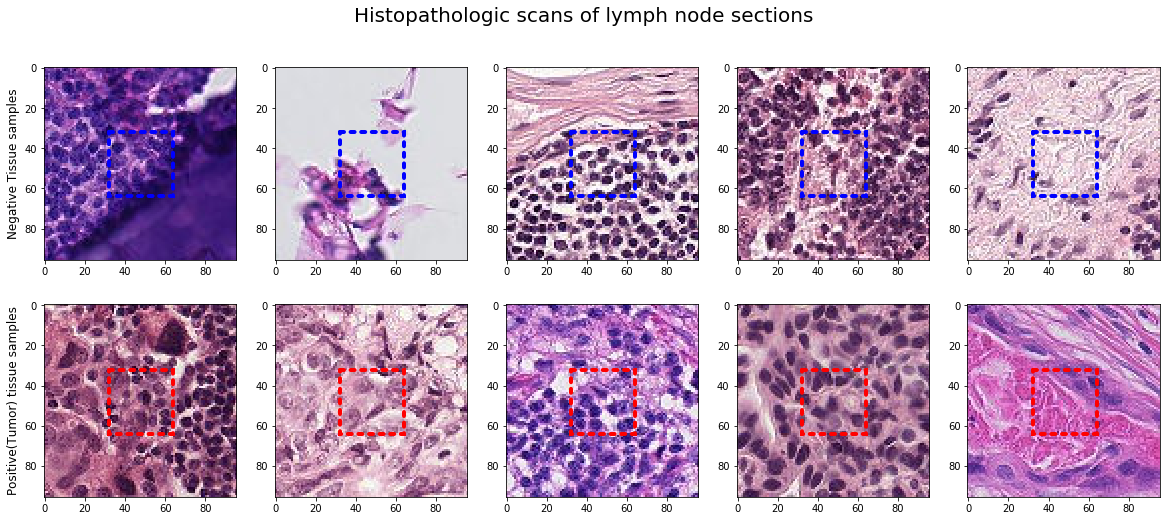

In [5]:
#Shuffling the Data and sampling it randomly
shuffled_data = shuffle(data)

fig, ax = plt.subplots(2, 5, figsize=(20,8))
fig.suptitle("Histopathologic scans of lymph node sections", fontsize=20)

#Negatives - Meaning having no cancer
for i, idx in enumerate(shuffled_data[shuffled_data["label"] == 0]["id"][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative Tissue samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Positive(Tumor) tissue samples', size='large')

### Note:
<hr>
The Original Images are of 96 X 96 pixels and the labels are only influenced by the center 32 X 32 pixels, so cropping it to 32 X 32 pixels would be a good idea (maybe), but if we do that we will loose a lot of information and ultimately our Model will not perform well, so to select the best pixels, we are approaching manually here so we are cropping it to 90 X 90 pixels and see how our model works and then we will select some other value.

# TODO:
Need to perform Hyper parameter tuning against the pixels using techniques like GridSearchCV or RandomSearch

## Image Processing and Data Augmentation

#### Need of Data Augmentation:
<ul>
    <li>Reduces Overfitting</li>
    <li>Model is more Generalised</li>
    <li>Model becomes unbiased</li>
</ul>

# TODO: 
Add markdown Cell explaining the type of Data Augmentation we are using


In [14]:
import random

ORIGINAL_IMAGE_SIZE = 96

# AUGMENTATION VARIABLES
CROP_SIZE = 90          # final size after crop
RANDOM_ROTATION = 3    # range (0-180), 180 allows all rotation variations, 0=no change
RANDOM_SHIFT = 2        # center crop shift in x and y axes, 0=no change. This cannot be more than (ORIGINAL_SIZE - CROP_SIZE)//2 
RANDOM_BRIGHTNESS = 7  # range (0-100), 0=no change
RANDOM_CONTRAST = 5    # range (0-100), 0=no change
RANDOM_90_DEG_TURN = 1  # 0 or 1= random turn to left or right


def readCroppedImage(path, augmentations = True):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_image = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_image)
    rgb_image = cv2.merge([r,g,b])
    
    if(not augmentations):
        return rgb_image / 255
    
    #random rotation
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1):
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48),rotation,1)   # the center point is the rotation anchor
    rgb_image = cv2.warpAffine(rgb_image,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_IMAGE_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_image = rgb_image[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    # Random flip
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor):
        rgb_image = rgb_image[:, ::-1]
    if(flip_ver):
        rgb_image = rgb_image[::-1, :]
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_image = rgb_image + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_image = rgb_image * cr
    
    # clip values to 0-1 range
    rgb_image = np.clip(rgb_image, 0, 1.0)
    
    return rgb_image

Text(0, 0.5, 'Tumor tissue samples')

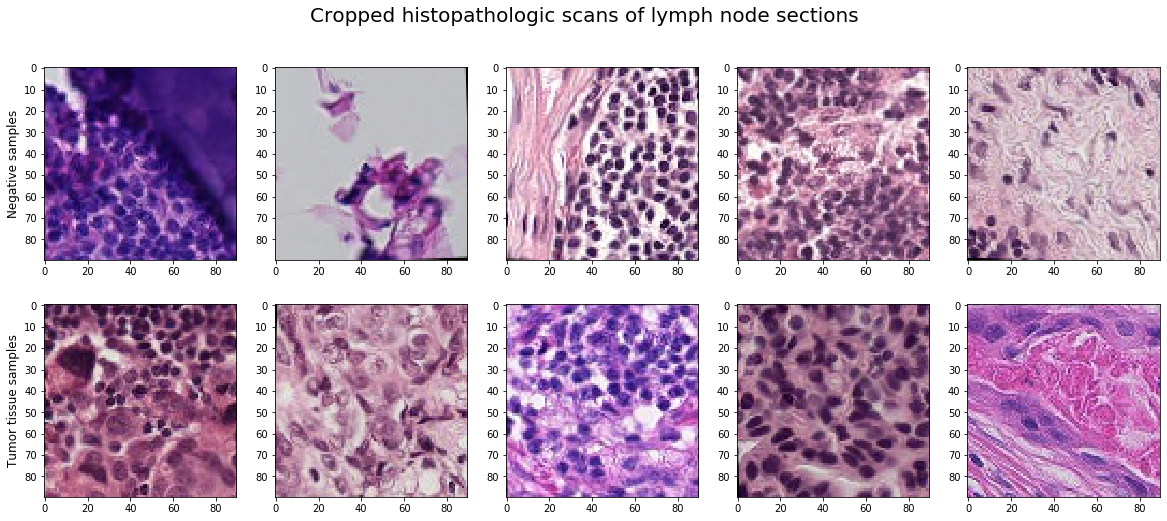

In [15]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Cropped histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif'))
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif'))
ax[1,0].set_ylabel('Tumor tissue samples', size='large')